### Sensitivity of hydraulic head at a point to uniform hydraulic conductivity for Thiem (1906) solution conditions

The sensitivity of hydraulic head ($h$) at a given point ($x'$) to uniform hydraulic conductivity ($K$) under steady state flow conditions in a radial one-dimensional plane (i.e. consistent with the Thiem [1906] analytical solution) can be calculated using an adjoint state-based approach as:
$$\begin{align}\cr
\frac{\partial h(r')}{\partial K}=\int\limits_R\nabla h\,(r)\cdot\nabla \psi^*(r)\; dr
\cr\cr\end{align}$$
This expression states that this sensitivity is equal to the spatial integral of the dot product of:
1. the divergence of hydraulic head, as calculated by the forward model; and,
2. the divergence of the adjoint state variable, as calculated by the adjoint state model. 

As shown, the spatial integration of the dot product of state variables is performed across the entire model domain.

### 1. Model setup

The Thiem (1906) analytical solution for the 1-D radial spatial distribution of hydraulic head at a point located radius $r$ from an extraction bore under steady state flow conditions is:
$$\begin{align}
h(r)=h_0-\frac{Q}{2\pi T}ln\left(\frac{r}{R}\right)
\cr\cr\end{align}$$
where $h_0 =$ initial hydraulic head, $Q =$ extraction flux $(L^3.T^{-1})$, $T =$ aquifer transmissivity $(L^2.T^{-1})$, and $R =$ radius of extraction influence $(L)$.

We define the Thiem solution as a callable function:

In [1]:
def Thiem(r, R, Q, T, h0):
    return h0-(Q/(2.*np.pi*T))*np.log(r/R)

We also define the numerical model as a callable function, since it will be used by each of:
1. The forward model, featuring a 'base' set of parameter values;
2. A perturbed version of the forward model, featuring an infinitesimal increase in $K$; and
3. The adjoint state model.

Each model is defined using the following five parameters:
1. Number of model columns ($ncol$)
2. Cell width along rows ($delr$)
3. Hydraulic conductivity ($K$)
4. Hydraulic head specified on Dirichlet boundary ($h_{\Gamma_1}$) 
5. Volumetric flux specified on Neumann boundary ($Q_{\Gamma_2}$) 

The variable $md$ is used to specify the working directory for each model.

Top and bottom of aquifer elevations are set to -100.0 and -101.0 metres respectively (resulting in an aquifer that is one metre thick) to ensure confined conditions.

Neumann boundary conditions are specified on the left-hand side of the model to represent an extraction bore.

Dirichlet boundary conditions are specified on the right-hand side of the model to represent lateral inflows.

Relatively tight convergence criteria values (i.e. 10$^{-6}$) are specified to ensure accuracy of perturbation-based sensitivities, which are based on differences between forward model outputs.

The location of the hydraulic head observation of interest is located at the midpoint of the model domain.

In [2]:
%matplotlib inline
import flopy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import flopy.utils.binaryfile as bf

def model(md, nrow, ncol, delr, K, h_BC1, Q_BC2):
    ml =  flopy.modflow.Modflow(modelname='model', model_ws=md)
    nrow = 1
    flopy.modflow.ModflowDis(ml, nlay=1, nrow=1, ncol=ncol, nper=1, delr=delr, delc=1., top=-100.0, botm=-101.0,
                             steady=True, perlen=1., nstp=1)
    ibound = np.ones([nrow, ncol], dtype=int)
    ibound[:, ncol-1] = -1 
    strt = h_BC1*np.ones([nrow, ncol], dtype=float)
    flopy.modflow.ModflowBas(ml, ibound=ibound, strt=strt)
    K = np.reshape([2.*np.pi*K*(delr*i+delr/2.) for i in range(ncol)], [1, ncol])
    flopy.modflow.ModflowLpf(ml, hk=K, vka=-999., ss=-999., sy=-999., layavg=1, ipakcb=53)
    flopy.modflow.ModflowWel(ml, stress_period_data={0: [0, 0, 0, Q_BC2]}, ipakcb=53)
    flopy.modflow.ModflowPcg(ml, hclose=1e-6, rclose=1e-6)
    flopy.modflow.ModflowOc(ml, stress_period_data={(0,0): ['save head', 'save budget']})
    return ml

flopy is installed in C:\Python27\Lib\site-packages\flopy


Values for the 'base' parameter set are defined as follows. These can be modified to demonstrate the method for other model configurations.

In [3]:
nrow  = 1
ncol  = 7
ocol  = (ncol-1)/2
delr  = 1.0
K     = 2.2
h_BC1 = 0.0
Q_BC2 = -1.0
dpar  = 1e-4

The forward model grid and boundary conditions can be presented visually as follows.

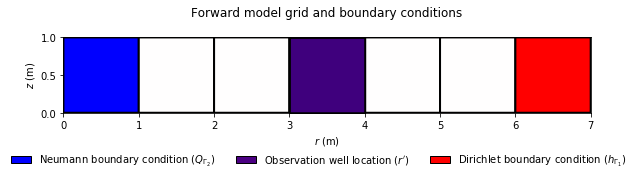

In [4]:
f,s = plt.subplots(1, 1, figsize=[24.00/2.54, 7.00/2.54])
s.set_aspect('equal')
s.set_title('Forward model grid and boundary conditions\n')
grid = np.hstack([np.zeros([1,1]), 0.5*np.ones([1, ncol-2]), np.ones([1,1])])
s.pcolor(grid, edgecolors='k', linewidths=2, cmap='bwr', vmin=0.0, vmax=1.0)
grid[0, ocol] = 2.
s.pcolor(np.ma.masked_not_equal(grid, 2.), edgecolors='k', linewidths=2, cmap='Purples', vmin=0.0, vmax=2.0)
s.set_xlabel('$r$ (m)')
s.set_ylabel('$z$ (m)')
l = f.legend(handles=[Patch(facecolor='b', edgecolor='k', label='Neumann boundary condition ($Q_{\Gamma_2}$)'),
                      Patch(facecolor='indigo', edgecolor='k', label="Observation well location ($r'$)"),
                      Patch(facecolor='r', edgecolor='k', label='Dirichlet boundary condition ($h_{\Gamma_1}$)')], 
             fancybox=False, frameon=False, loc=8, ncol=3)

### 2. Sensitivity calculation using perturbation-based approach

First, the forward model featuring the 'base' parameter set is run.

In [5]:
md = 'forward_base'
ml = model(md, nrow, ncol, delr, K, h_BC1, Q_BC2)    

ml.write_input()
success, buff = ml.run_model(silent=True)
hds_base = bf.HeadFile(md+'/'+'model.hds').get_data()[0,:,:]
hob_base = float(hds_base[0, ocol])

The spatial distribution of hydraulic head calculated by the 'base' forward model can be presented visually as follows.

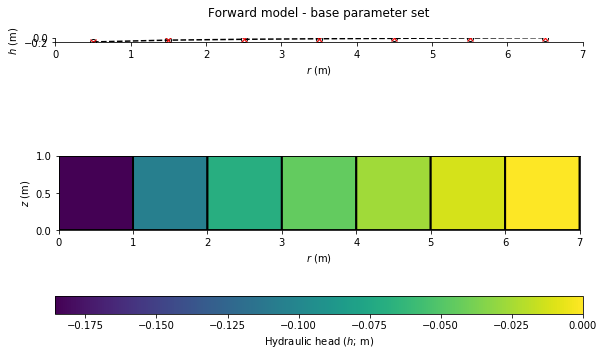

In [6]:
f,s = plt.subplots(2, 1, figsize=[24.00/2.54, 17.00/2.54])
s[0].set_aspect(0.3)
s[0].set_title('Forward model - base parameter set\n')
s[0].plot(delr/2.+np.arange(ncol), hds_base.flatten(), 'ko--', mfc='none')
s[0].set_xlabel('$r$ (m)')
s[0].set_ylabel('$h$ (m)')
s[0].spines['top'].set_visible(False)            
s[0].spines['right'].set_visible(False)            
s[1].set_aspect('equal')
p = s[1].pcolor(hds_base, edgecolors='k', linewidths=2, cmap='viridis')
s[1].set_xlabel('$r$ (m)')
s[1].set_ylabel('$z$ (m)')
l = f.colorbar(p, orientation='horizontal', pad=0.4, aspect=30, label='Hydraulic head ($h$; m)')
d = s[0].set_xlim(s[1].get_xlim())

s[0].plot(delr/2.+delr*np.arange(ncol), [Thiem(r, R=delr*ncol, Q=Q_BC2, T=K, h0=h_BC1) 
                                         for r in delr/2.+delr*np.arange(ncol)], 'x', mec='r', mfc='none')

Second, the forward model featuring the perturbed parameter set is run. 

In [7]:
md = 'forward_perturbed'
ml = model(md, nrow, ncol, delr, K, h_BC1, Q_BC2)    

ml.remove_package('lpf')
hk = np.reshape([2.*np.pi*K*(1.0+dpar)*(delr*i+delr/2.) for i in range(ncol)], [1, ncol])  
flopy.modflow.ModflowLpf(ml, hk=hk, vka=-999., ss=-999., sy=-999., layavg=1, ipakcb=53)

ml.write_input()
success, buff = ml.run_model(silent=True)
hds_pert = bf.HeadFile(md+'/'+'model.hds').get_data()[0,:,:]
hob_pert = float(hds_pert[0, ocol])

The spatial distribution of hydraulic head calculated by the perturbed forward model can be presented visually as follows.

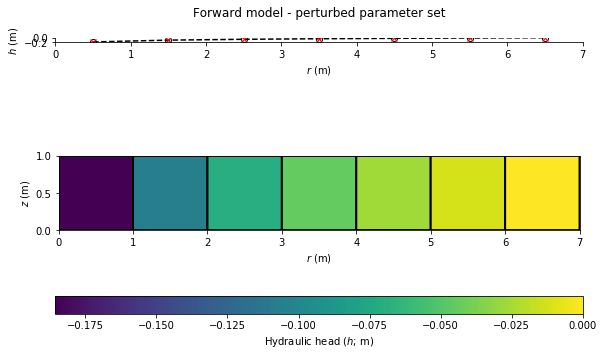

In [8]:
f,s = plt.subplots(2, 1, figsize=[24.00/2.54, 17.00/2.54])
s[0].set_aspect(0.3)
s[0].set_title('Forward model - perturbed parameter set\n')
s[0].plot(delr/2.+np.arange(ncol), hds_pert.flatten(), 'ko--', mfc='none')
s[0].set_xlabel('$r$ (m)')
s[0].set_ylabel('$h$ (m)')
s[0].spines['top'].set_visible(False)            
s[0].spines['right'].set_visible(False)            
s[1].set_aspect('equal')
p = s[1].pcolor(hds_pert, edgecolors='k', linewidths=2, cmap='viridis')
s[1].set_xlabel('$r$ (m)')
s[1].set_ylabel('$z$ (m)')
l = f.colorbar(p, orientation='horizontal', pad=0.4, aspect=30, label='Hydraulic head ($h$; m)')
d = s[0].set_xlim(s[1].get_xlim())

s[0].plot(delr/2.+delr*np.arange(ncol), [Thiem(r, R=delr*ncol, Q=Q_BC2, T=K*(1.0+dpar), h0=h_BC1) 
                                         for r in delr/2.+delr*np.arange(ncol)], 'x', mec='r', mfc='none')

Third, the perturbation-based sensitivity is calculated.

In [9]:
dhdK_pert = (hob_pert-hob_base)/(K*dpar)

### 3. Sensitivity calculation using adjoint state-based approach

First, the adjoint state model is defined. This is mostly identical to the forward model, except for three conditions: 
1. The value specified on the Dirichlet boundary condition is set to zero.
2. The Neumann boundary condition is omitted.
3. A constant source of adjoint state is specified at the location of the hydraulic head observation of interest using a  source term with flux magnitude equal to unity.

In [10]:
md = 'adjoint'
ml = model(md, nrow, ncol, delr, K, h_BC1, Q_BC2)    

ml.remove_package('bas6')
ibound = np.ones([nrow, ncol], dtype=int)
ibound[:, ncol-1] = -1
strt = np.zeros([nrow, ncol])
flopy.modflow.ModflowBas(ml, ibound=ibound, strt=strt)

ml.remove_package('wel')
flopy.modflow.ModflowWel(ml, stress_period_data={0: [0, 0, ocol, 1.]}, ipakcb=53)

ml.write_input()
success, buff = ml.run_model(silent=True)
adj = bf.HeadFile(md+'/'+'model.hds').get_data()[0,:,:]

The adjoint state model grid and boundary conditions can be presented visually as follows.

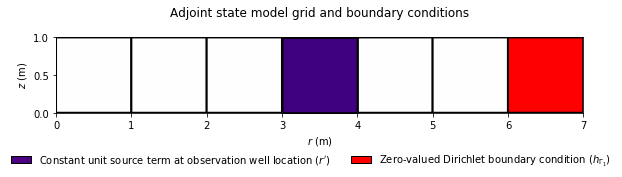

In [11]:
f,s = plt.subplots(1, 1, figsize=[24.00/2.54, 7.00/2.54])
s.set_aspect('equal')
s.set_title('Adjoint state model grid and boundary conditions\n')
grid = np.hstack([0.5*np.ones([1, ncol-1]), np.ones([1,1])])
s.pcolor(grid, edgecolors='k', linewidths=2, cmap='bwr', vmin=0.0, vmax=1.0)
grid[0, ocol] = 2.
s.pcolor(np.ma.masked_not_equal(grid, 2.), edgecolors='k', linewidths=2, cmap='Purples', vmin=0.0, vmax=2.0)
s.set_xlabel('$r$ (m)')
s.set_ylabel('$z$ (m)')
l = f.legend(handles=[Patch(facecolor='indigo', edgecolor='k', 
                            label="Constant unit source term at observation well location ($r'$)"),
                      Patch(facecolor='r', edgecolor='k', 
                            label='Zero-valued Dirichlet boundary condition ($h_{\Gamma_1}$)')], 
             fancybox=False, frameon=False, loc=8, ncol=3)

The spatial distribution of the adjoint state variable calculated by the adjoint model can be presented visually as follows. Note that the value of the adjoint state variable is zero at the right-most cell; this is because the Dirichlet boundary condition is zero-valued in the adjoint state model.

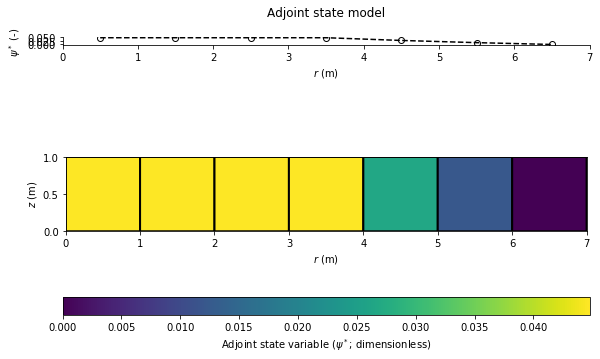

In [12]:
f,s = plt.subplots(2, 1, figsize=[24.00/2.54, 17.00/2.54])
s[0].set_aspect(2.)
s[0].set_title('Adjoint state model\n')
s[0].plot(0.5+np.arange(ncol), adj.flatten(), 'ko--', mfc='none')
s[0].set_xlabel('$r$ (m)')
s[0].set_ylabel('$\psi^*$ (-)')
s[0].spines['top'].set_visible(False)            
s[0].spines['right'].set_visible(False)            
s[1].set_aspect('equal')
p = s[1].pcolor(adj, edgecolors='k', linewidths=2, cmap='viridis')
s[1].set_xlabel('$r$ (m)')
s[1].set_ylabel('$z$ (m)')
l = f.colorbar(p, orientation='horizontal', pad=0.4, aspect=30, 
               label='Adjoint state variable ($\psi^*$; dimensionless)')
d = s[0].set_xlim(s[1].get_xlim())

Second, the adjoint state sensitivity is calculated. For this example [i.e. for the sensitivity $\partial h(r')/\partial K$], this is calculated using a combination of forward and adjoint model outputs, as described by the equation presented above.

In [21]:
#dhdK_adj  = -np.sum(np.gradient(hds_base.flatten())*np.gradient(adj.flatten()))*((float(ncol)-1)/float(ncol))
dhdx_base = hds_base.flatten()[:-1]-hds_base.flatten()[1:]
print 'dhdx_base = ',dhdx_base

dhdx_adj  = adj.flatten()[:-1]-adj.flatten()[1:]
print 'dhdx_adj  = ',dhdx_adj

dhdK_adj  = -np.sum(dhdx_base*dhdx_adj)

dhdx_base =  [-0.07947707 -0.03695474 -0.02434146 -0.01818088 -0.01451715 -0.01208522]
dhdx_adj  =  [0.         0.         0.         0.01818088 0.01451715 0.01208522]


This comparison of divergence term values shows that the contribution of cells located upgradient of the observation location to the adjoint sensitivity will be zero.

### 4. Comparison of calculated sensitivities

In [22]:
print 'Perturbation-based sensitivity  = '+str('%14.6f'%  dhdK_pert)
print 'Adjoint state-based sensitivity = '+str('%14.6f'%  dhdK_adj)
print
print 'Ratio                           = '+str('%14.6e'% (dhdK_pert/dhdK_adj))
print 'Difference (absolute)           = '+str('%14.6e'% (dhdK_adj-dhdK_pert))
print 'Difference (percent)            = '+str('%14.6e'%  abs((dhdK_adj-dhdK_pert)/dhdK_pert))

Perturbation-based sensitivity  =       0.020354
Adjoint state-based sensitivity =       0.000687

Ratio                           =   2.961198e+01
Difference (absolute)           =  -1.966629e-02
Difference (percent)            =   9.662299e-01
